In [1]:
!pip install pandas_datareader
import pandas_datareader as pdr

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
key='88db83f661bb558f2d29049f89d71911d5a30f98'
df = pdr.get_data_tiingo('AAPL', api_key=key)

In [3]:
import pandas as pd
import numpy as np

In [4]:
df.to_csv('AAPL.csv')

In [5]:
df = pd.read_csv('AAPL.csv')
df

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-07-21 00:00:00+00:00,130.75,132.92,130.32,132.85,76756427,120.489185,122.488891,120.092930,122.424384,76756427,0.0,1.0
1,AAPL,2015-07-22 00:00:00+00:00,125.22,125.50,121.99,121.99,115450607,115.393160,115.651187,112.416640,112.416640,115450607,0.0,1.0
2,AAPL,2015-07-23 00:00:00+00:00,125.16,127.09,125.06,126.20,50999452,115.337869,117.116409,115.245717,116.296253,50999452,0.0,1.0
3,AAPL,2015-07-24 00:00:00+00:00,124.50,125.74,123.90,125.32,42162332,114.729663,115.872352,114.176749,115.485313,42162332,0.0,1.0
4,AAPL,2015-07-27 00:00:00+00:00,122.77,123.61,122.12,123.09,44455540,113.135428,113.909508,112.536438,113.430315,44455540,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,AAPL,2020-07-13 00:00:00+00:00,381.91,399.82,381.03,389.06,47913100,381.910000,399.820000,381.030000,389.060000,47913100,0.0,1.0
1254,AAPL,2020-07-14 00:00:00+00:00,388.23,389.02,375.51,379.36,42748100,388.230000,389.020000,375.510000,379.360000,42748100,0.0,1.0
1255,AAPL,2020-07-15 00:00:00+00:00,390.90,396.99,385.96,395.96,38306900,390.900000,396.990000,385.960000,395.960000,38306900,0.0,1.0
1256,AAPL,2020-07-16 00:00:00+00:00,386.09,389.62,383.62,386.25,27645900,386.090000,389.620000,383.620000,386.250000,27645900,0.0,1.0


In [6]:
df2 = df.reset_index()['close']
df2[1228:]

1228    331.50
1229    333.46
1230    343.99
1231    352.84
1232    335.90
1233    338.80
1234    342.99
1235    352.08
1236    351.59
1237    351.73
1238    349.72
1239    358.87
1240    366.53
1241    360.06
1242    364.84
1243    353.63
1244    361.78
1245    364.80
1246    364.11
1247    364.11
1248    373.85
1249    372.69
1250    381.37
1251    383.01
1252    383.68
1253    381.91
1254    388.23
1255    390.90
1256    386.09
1257    385.31
Name: close, dtype: float64

In [7]:
df2.shape

(1258,)

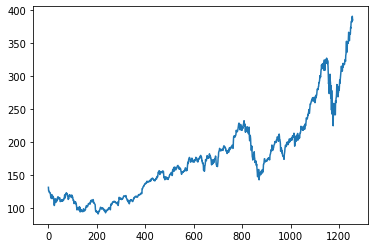

In [8]:
import matplotlib.pyplot as plt
plt.plot(df2)

In [9]:
# LSTM are sensitive to the scale of the data. So we apply MinMax scalar

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(1258, 1)

In [11]:
# Splitting dataset into train and test split

training_size = int(len(df2)*0.7)
test_size = len(df2) - training_size
train_data, test_data = df2[0:training_size,:],df2[training_size:len(df2),:1]

In [12]:
#print(train_data)

In [13]:
# convert an array of values into a dataset matrix
import numpy
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        ###i=0,1,2,3,4,5,6,7,8,9 No. of past values we want to consider 
        dataX.append(a) # so this will have 10 values, 11th values will be appended in dataY
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [14]:
# reshape into x=t, t+1, t+2, t+3 and t+4 depending on the time_step value

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [15]:
# reshape input to be [samples, timesteps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [16]:
!pip install tensorflow 

In [17]:
# Create LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [18]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) #input_shape which is (X_train.shape[1],1)
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',
             optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:


model.fit(X_train, y_train, validation_data=(X_test,y_test), 
          epochs=20, batch_size=16, verbose=1)

Epoch 1/20
49/49 [==============================] - 5s 92ms/step - loss: 0.0054 - val_loss: 0.0083
Epoch 2/20
49/49 [==============================] - 3s 69ms/step - loss: 7.4104e-04 - val_loss: 0.0083
Epoch 3/20
49/49 [==============================] - 3s 69ms/step - loss: 5.1944e-04 - val_loss: 0.0065
Epoch 4/20
49/49 [==============================] - 3s 69ms/step - loss: 5.0355e-04 - val_loss: 0.0041
Epoch 5/20
49/49 [==============================] - 3s 68ms/step - loss: 3.8722e-04 - val_loss: 0.0061
Epoch 6/20
49/49 [==============================] - 3s 70ms/step - loss: 3.6248e-04 - val_loss: 0.0058
Epoch 7/20
49/49 [==============================] - 3s 69ms/step - loss: 3.5301e-04 - val_loss: 0.0060
Epoch 8/20
49/49 [==============================] - 3s 69ms/step - loss: 3.2842e-04 - val_loss: 0.0062
Epoch 9/20
49/49 [==============================] - 3s 69ms/step - loss: 4.8787e-04 - val_loss: 0.0108
Epoch 10/20
49/49 [==============================] - 3s 69ms/step - loss: 3.7

In [21]:
import tensorflow as tf

In [22]:
# prediction and check the performance metrics

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [23]:
# transformback to the original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [24]:
# calculate RMSE performance metrics

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

151.80520427919004

In [25]:
# Test data RMSE

math.sqrt(mean_squared_error(y_test,test_predict))

261.0898807918203

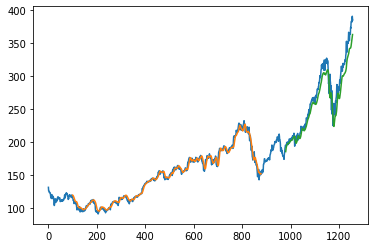

In [26]:
# Plotting

# shift train predictions for plotting
look_back = 100
trainPredictPlot = numpy.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) + 1: len(df2) -1, :] = test_predict

#plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [27]:
len(test_data)

378

In [28]:
# forcasting values using last 100 values

print(len(test_data))
x_input = test_data[278:].reshape(-1,1)
x_input.shape

378


(100, 1)

In [35]:
x_input.shape

(37, 1)

In [29]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [30]:
# demonstrate prediction for next 10 days

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape(1, n_steps, 1)
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        

print(lst_output)

[0.9130516]
2
[0.9130516]
3
[0.9130516]
4
[0.9130516]
5
[0.9130516]
6
[0.9130516]
7
[0.9130516]
8
[0.9130516]
9
[0.9130516]
10
[0.9130516]
11
[0.9130516]
12
[0.9130516]
13
[0.9130516]
14
[0.9130516]
15
[0.9130516]
16
[0.9130516]
17
[0.9130516]
18
[0.9130516]
19
[0.9130516]
20
[0.9130516]
21
[0.9130516]
22
[0.9130516]
23
[0.9130516]
24
[0.9130516]
25
[0.9130516]
26
[0.9130516]
27
[0.9130516]
28
[0.9130516]
29
[0.9130516]
30
[0.9130516]
31
[[0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130516052246094], [0.9130

In [37]:
# plotting the forcasting values

day_new = np.arange(1,101) #taking last 100 values
day_pred = np.arange(101,131) #forecast next 30 values
day_pred

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130])

In [36]:
df3 = df2.tolist()
df3.extend(lst_output)
plt.show(df3[1000:])

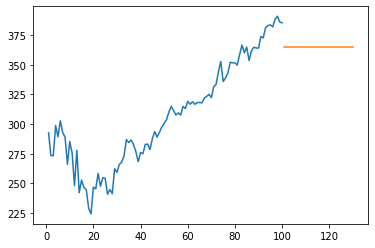

In [34]:
plt.plot(day_new,scaler.inverse_transform(df2[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))